In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5.0, 3.0]
plt.rcParams['figure.dpi'] = 150
%matplotlib notebook

In [3]:
true_data = pd.read_csv("csv_data/srilanka.txt",sep=' ', skipinitialspace=True, \
                        skiprows=1, header=None, names=['confirmed', 'recovered', 'deaths'])
true_data

,confirmed,recovered,deaths
0,3382,3233,13
1,3388,3245,13
2,3395,3254,13
3,3402,3258,13
4,3513,3259,13
...,...,...,...
419,559605,0,14205
420,560345,0,14232
421,561059,0,14258
422,561778,0,14278


In [4]:
smoothed_data = pd.read_csv("../C++/build/release/results/srilanka_popsmooth.txt", skipinitialspace=True, \
                            header=None, names=['confirmed_true', 'deaths_true', 'confirmed_smooth', 'deaths_smooth', 'vaccine_smooth'])
diff_data = smoothed_data.diff();
diff_data.loc[0] = 0
smoothed_data

,confirmed_true,deaths_true,confirmed_smooth,deaths_smooth,vaccine_smooth
0,3382,13,3382,13,0
1,3388,13,3388,13,0
2,3395,13,3416,13,0
3,3402,13,3684,13,0
4,3513,13,3842,13,0
...,...,...,...,...,...
419,559605,14205,559376,14206,13718315
420,560345,14232,560218,14231,13723061
421,561059,14258,561061,14256,13727408
422,561778,14278,561786,14280,13731016


<IPython.core.display.Javascript object>


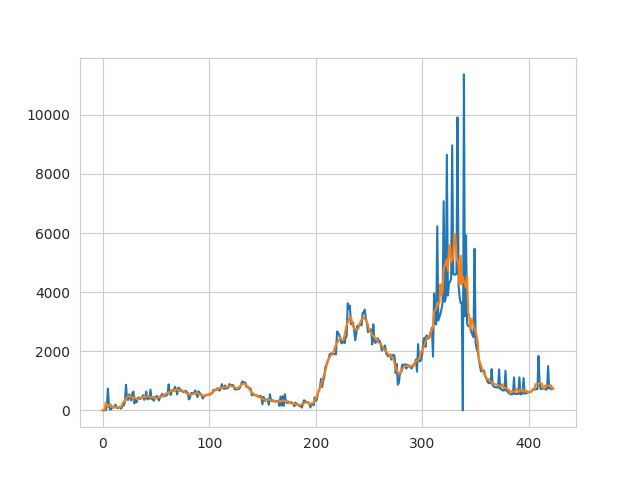

In [5]:
plt.figure()
plt.plot(diff_data['confirmed_true'])
plt.plot(diff_data['confirmed_smooth'])
plt.show()

<IPython.core.display.Javascript object>


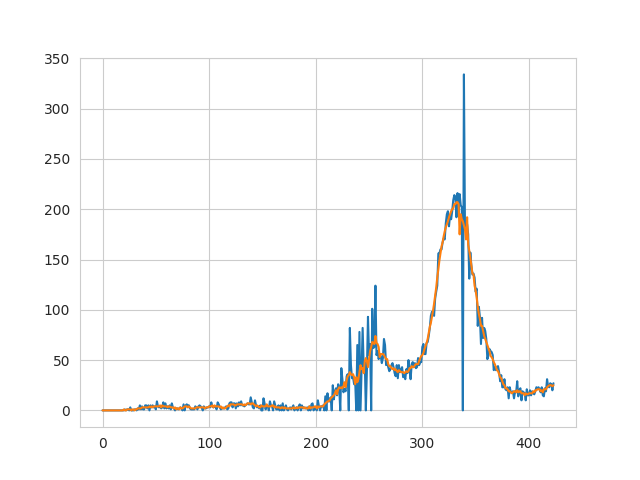

In [6]:
plt.figure()
plt.plot(diff_data['deaths_true'])
plt.plot(diff_data['deaths_smooth'])
plt.show()

<IPython.core.display.Javascript object>


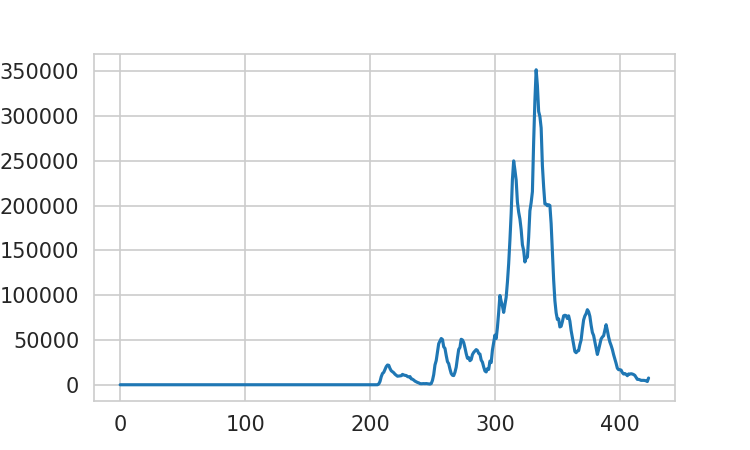

In [73]:
plt.figure()
plt.plot(diff_data['vaccine_smooth'])
plt.show()

In [1]:
pred_data = pd.read_csv("../C++/build/release/results/srilanka_prediction_seed1.txt", \
                        skipinitialspace=True)
#print("pred_data:\n", pred_data)
num_days = len(pred_data)
print("Num days:", num_days)

param_data = pd.read_csv("../C++/build/release/results/srilanka_params_seed1.txt", \
                        skipinitialspace=True,header=None)
# param_data = param_data.iloc[:, ::-1];
#print(param_data)

beta = param_data.loc[0:num_days-1]
c    = param_data.loc[  num_days:2*num_days-1]
IFR  = param_data.loc[2*num_days:3*num_days-1]

num_sol_to_plot = min(10, len(param_data.columns));

T_incub = param_data.loc[param_data.index[-6]]
T_recov = param_data.loc[param_data.index[-5]]
beta_vac_scaling = param_data.loc[param_data.index[-4]]
vaccine_alpha = param_data.loc[param_data.index[-3]]
IFR_scaling = param_data.loc[param_data.index[-2]]
#print("Vaccine effectiveness:\n",vaccine_eff)

print("T_incub:\n", T_incub)
print("T_recov:\n", T_recov)
print("beta_vac_scaling:\n", beta_vac_scaling)
print("vaccine_alpha:\n", vaccine_alpha)
print("IFR_scaling:\n", IFR_scaling)

optimal_params = {
    "beta": beta[0].tolist(),
    "c"   : c[0].tolist(),
    "IFR"  : IFR[0].tolist(),
    "beta_vac_scaling": beta_vac_scaling[0],
    "vaccine_alpha": vaccine_alpha[0],
    "IFR_scaling": IFR_scaling[0]
}

#Write optimal parameters as JS variable
opt_param_json_file = open("optimal_parameters.js", "w")
opt_param_json_file.write("let optimal_model_params = ")
json.dump(optimal_params, opt_param_json_file)
opt_param_json_file.close()

error = param_data.loc[param_data.index[-1]]
error_plot = error[0:num_sol_to_plot]
print("Error:\n",error)

scaled_error = (np.log(error_plot) - np.log(min(error_plot))) / (np.log(max(error_plot)) - np.log(min(error_plot))) * 0.9
print("Scaled error:\n", scaled_error)
grey_colors = np.tile(scaled_error,[3,1]).transpose();

# grey_colormap = matplotlib.colors.ListedColormap(grey_colors)
grey_colors[0] = [0.24, 0.63, 0.93] #Change color of best result to blue
print("Grey colors:\n", grey_colors)
# plt.figure()
# ax = sns.heatmap(np.random.rand(30,30))
# ax.pcolor(np.random.rand(30,30),cmap=grey_colormap)
# plt.show()

start_date = datetime.strptime("2020-10-1", "%Y-%m-%d")
dates = [];
for i in range(0,num_days):
    dates.append(start_date + timedelta(days=i))

locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)

NameError: name 'pd' is not defined

<IPython.core.display.Javascript object>


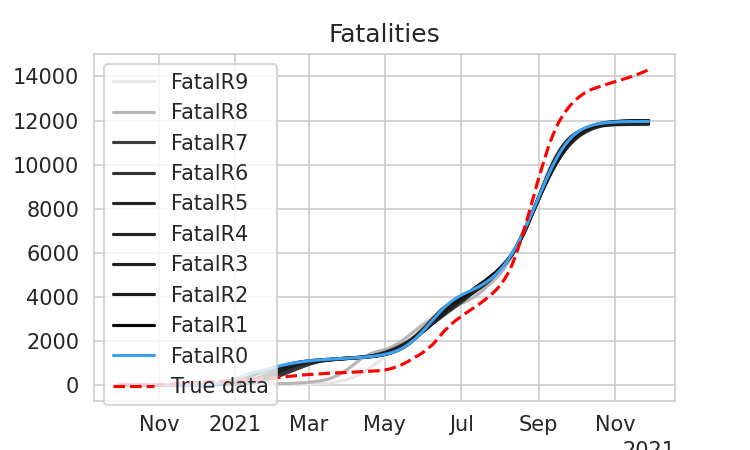

In [84]:
pred_fatal = pred_data.filter(regex=("FatalR.*"))

fig = plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates,pred_fatal["FatalR"+str(i)], color=grey_colors[i])
    
plt.plot(dates,smoothed_data["deaths_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
    
labels = pred_fatal.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Fatalities')
plt.show()


<IPython.core.display.Javascript object>


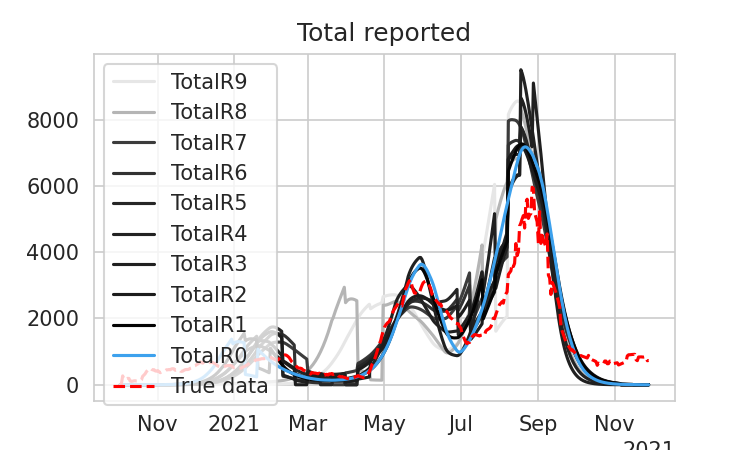

In [93]:
pred_reported = pred_data.filter(regex=("TotalR.*"))
# print(pred_reported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_reported["TotalR"+str(i)].diff(), color=grey_colors[i])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["confirmed_smooth"].diff(),'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_reported.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Total reported')
plt.show()

      TotalVac0   TotalVac1   TotalVac2     TotalVac3     TotalVac4  \
0           0.0         0.0         0.0  0.000000e+00  0.000000e+00   
1           0.0         0.0         0.0  0.000000e+00  0.000000e+00   
2           0.0         0.0         0.0  0.000000e+00  0.000000e+00   
3           0.0         0.0         0.0  0.000000e+00  0.000000e+00   
4           0.0         0.0         0.0  0.000000e+00  0.000000e+00   
..          ...         ...         ...           ...           ...   
419  13713398.0  13713398.0  13713398.0  1.371340e+07  1.371340e+07   
420  13718315.0  13718315.0  13718315.0  1.371831e+07  1.371831e+07   
421  13723061.0  13723061.0  13723061.0  1.372306e+07  1.372306e+07   
422  13727408.0  13727408.0  13727408.0  1.372741e+07  1.372741e+07   
423  13731016.0  13731016.0  13731016.0  1.373102e+07  1.373102e+07   

      TotalVac5   TotalVac6   TotalVac7   TotalVac8   TotalVac9  ...  \
0           0.0         0.0         0.0         0.0         0.0  ...   
1  

<IPython.core.display.Javascript object>


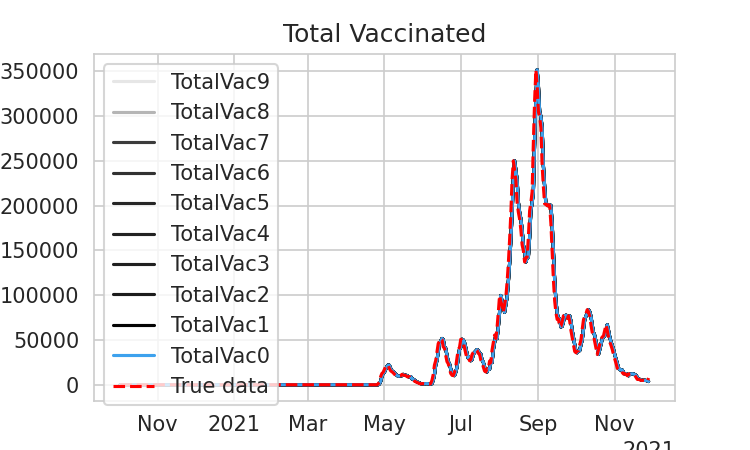

In [86]:
pred_vaccine = pred_data.filter(regex=("TotalVac.*"))
print(pred_vaccine)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_vaccine["TotalVac"+str(i)].diff(), color=grey_colors[i])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["vaccine_smooth"].diff(),'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_vaccine.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Total Vaccinated')
plt.show()

<IPython.core.display.Javascript object>


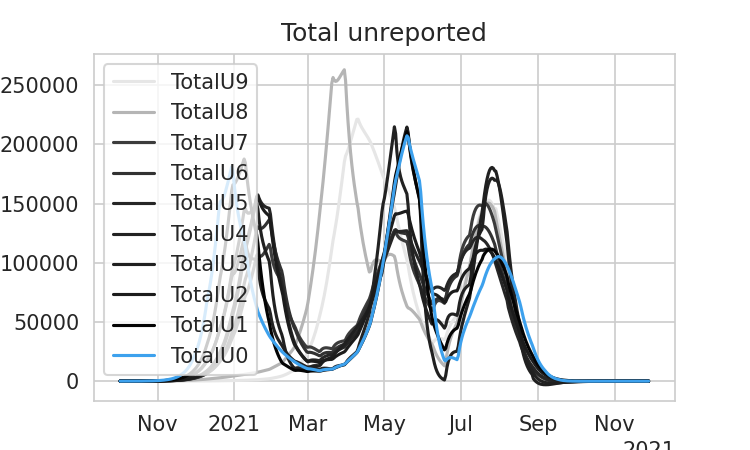

In [87]:
pred_unreported = pred_data.filter(regex=("TotalU.*"))
# print(pred_unreported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_unreported["TotalU"+str(i)].diff(), color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_unreported.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Total unreported')
plt.show()

        Reff0     Reff1     Reff2     Reff3     Reff4     Reff5     Reff6  \
0    0.201212  4.034511  3.676319  2.846921  0.125462  3.619979  2.857151   
1    0.201212  4.034510  3.676319  2.846921  0.125462  3.619979  2.857151   
2    0.201212  4.034509  3.676318  2.846920  0.125462  3.619978  2.857150   
3    0.201212  4.034507  3.676316  2.846918  0.125462  3.619977  2.857149   
4    0.201212  4.034505  3.676314  2.846916  0.125462  3.619975  2.857148   
..        ...       ...       ...       ...       ...       ...       ...   
419  0.035269  0.041695  0.049597  0.001368  0.002232  0.030907  0.024725   
420  0.035245  0.041667  0.049563  0.001367  0.002230  0.030886  0.024708   
421  0.035222  0.041639  0.049531  0.001366  0.002229  0.030865  0.024692   
422  0.035200  0.041614  0.049501  0.001365  0.002227  0.030847  0.024677   
423  0.035183  0.041593  0.049476  0.001365  0.002226  0.030831  0.024664   

        Reff7     Reff8     Reff9  ...    Reff40    Reff41    Reff42  \
0  

<IPython.core.display.Javascript object>


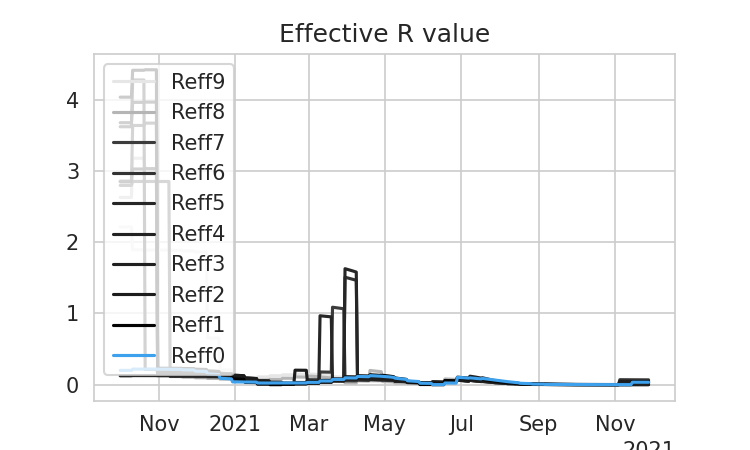

In [88]:
pred_Reff = pred_data.filter(regex=("Reff.*"))
print(pred_Reff)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_Reff["Reff"+str(i)], color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_Reff.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Effective R value')
plt.show()

<IPython.core.display.Javascript object>


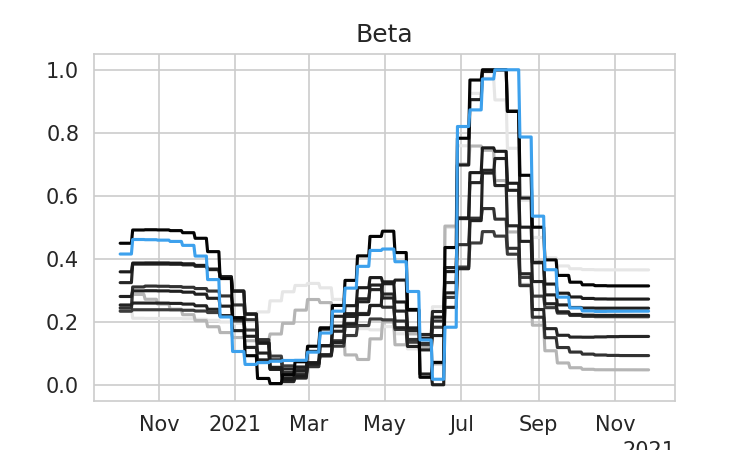

<IPython.core.display.Javascript object>


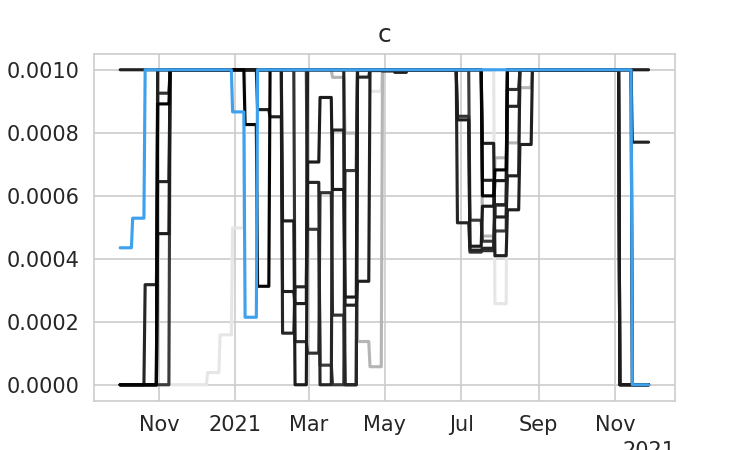

In [89]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, beta[i], color=grey_colors[i])
# sns.lineplot(data=beta,palette=grey_colormap, dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('Beta')
plt.show()

plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, c[i], color=grey_colors[i])
# sns.lineplot(data=c0,palette="Greys_r", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('c')
plt.show()

# print(sns.color_palette("light:#5A9")[0])

<IPython.core.display.Javascript object>


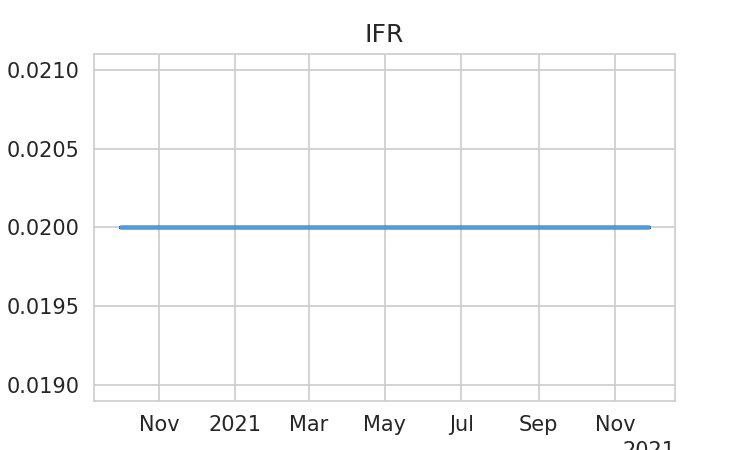

In [91]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, IFR[i], color=grey_colors[i])
# sns.lineplot(data=IFR,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('IFR')
plt.show()

In [13]:

err_t = (pred_data['TotalR0'] - smoothed_data["confirmed_smooth"])
err_f = (pred_data['FatalR0'] - smoothed_data["deaths_smooth"])
cost_t = np.linalg.norm(err_t)**2 / np.linalg.norm(smoothed_data["confirmed_smooth"])**2;
cost_f = np.linalg.norm(err_f)**2 / np.linalg.norm(smoothed_data["deaths_smooth"])**2
print(cost_t, cost_f, cost_t+cost_f)
#print(smoothed_data["confirmed_smooth"])

0.020291039815172465 0.022915442054805887 0.04320648186997835


In [ ]:
print(err_t)
print(format(np.linalg.norm(smoothed_data["confirmed_smooth"])**2, '1.8e'))
print(format(np.linalg.norm(smoothed_data["deaths_smooth"])**2, '1.8e'))